In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
csv_path = './content/MyDrive/drive/data/csv'
artist_train = pd.read_csv('/content/drive/MyDrive/data/csv/Artist/artist_train')
# lets visualize one imag
base_url = '/content/drive/MyDrive/data/image/wikiart'

In [ ]:
# lets start creating data
artist = '/content/drive/MyDrive/data/csv/Artist'
genre = '/content/drive/MyDrive/data/csv/Genre'
style = '/content/drive/MyDrive/data/csv/Style'
data_dir = '/content/drive/MyDrive/data/csv'

artist_train_path = data_dir + '/artist_train.csv'
artist_val_path = data_dir + '/artist_val.csv'
artist_class_path = data_dir + '/artist_class.txt'

genre_train_path = data_dir + '/genre_train.csv'
genre_val_path = data_dir + '/genre_val.csv'
genre_class_path = data_dir + '/genre_class.txt'

style_train_path = data_dir + '/style_train.csv'
style_val_path = data_dir + '/style_val.csv'
style_class_path = data_dir + '/style_class.txt'

artist_train = pd.read_csv(data_dir + '/artist_train.csv')
artist_val = pd.read_csv(data_dir + '/artist_val.csv')
artist_class = pd.read_csv(artist_class_path, header=None, names=["artist_name"])

genre_train = pd.read_csv(data_dir + '/genre_train.csv')
genre_val = pd.read_csv(data_dir + '/genre_val.csv')
genre_class = pd.read_csv(genre_class_path, header=None, names=["genre_name"])


style_train = pd.read_csv(data_dir + '/style_train.csv')
style_val = pd.read_csv(data_dir + '/style_val.csv')
style_class = pd.read_csv(style_class_path, header=None, names=["style_name"])

genre_class['genre_name'][1]

'cityscape'

Creating balanced artist dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 13344/13344 [00:00<00:00, 17076.30it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 7966.72it/s]


Filling missing slots...
Shuffling dataset...
Filtering missing images...
Grouping images by class...


Processing rows: 100%|██████████| 5706/5706 [00:00<00:00, 25468.77it/s]


Balancing dataset...


Processing classes: 100%|██████████| 23/23 [00:00<00:00, 27586.21it/s]


Filling missing slots...
Shuffling dataset...
Artist balanced dataset size: 4600 1150


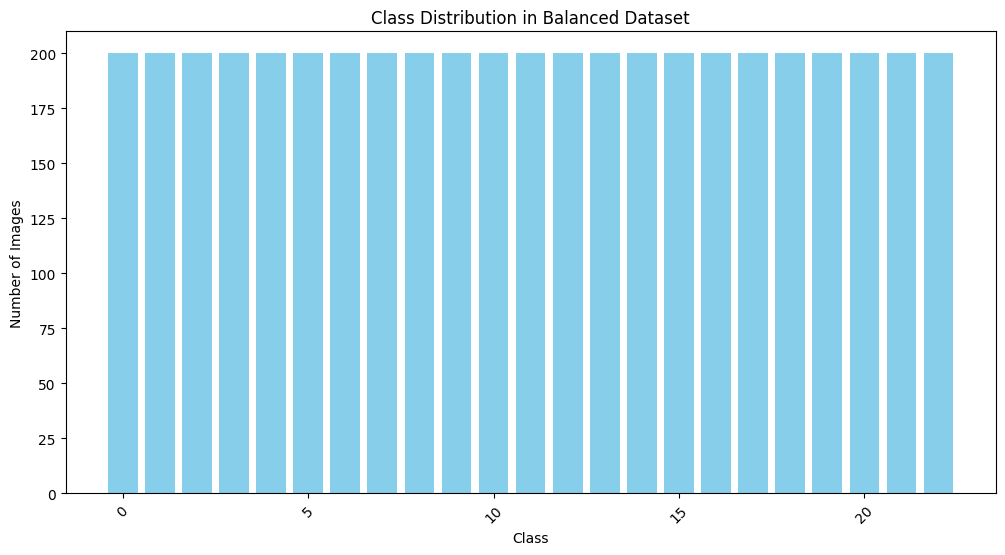

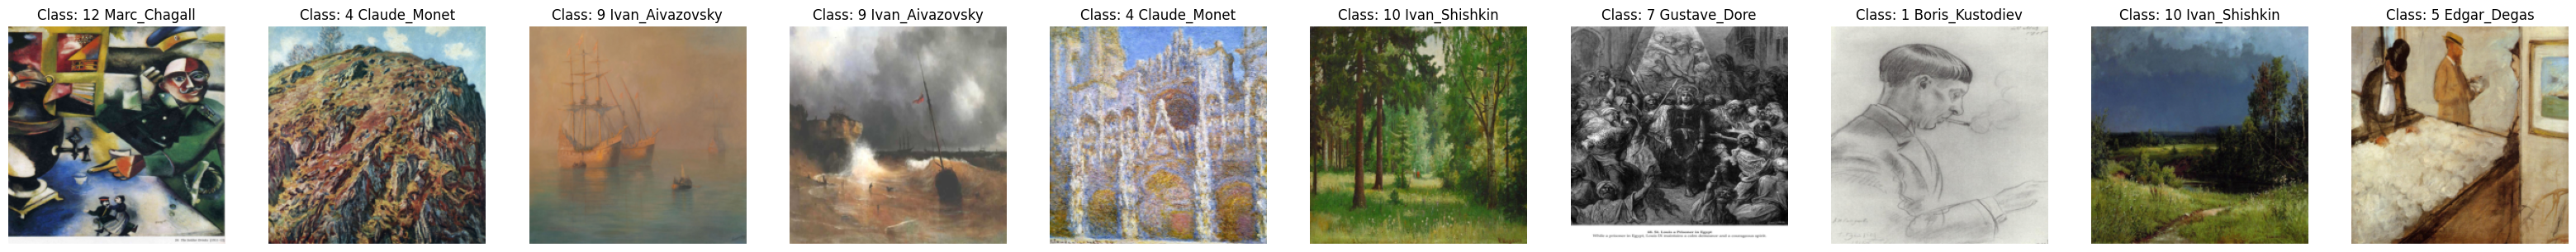

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from collections import defaultdict
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define dataset class
class BalancedArtDataset(Dataset):
    def __init__(self, csv_file, img_dir, class_mapping, transform=None, images_per_class=32):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.class_mapping = class_mapping
        self.transform = transform
        self.images_per_class = images_per_class

        # Filter out missing images
        print("Filtering missing images...")
        self.data = self.data[self.data.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, str(x))))]

        # Group images by class
        print("Grouping images by class...")
        self.class_images = defaultdict(list)
        for _, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Processing rows"):
            self.class_images[row.iloc[1]].append(row)

        # Balance dataset with 32 images per class
        print("Balancing dataset...")
        self.final_data = []
        all_images = []
        for cls, images in tqdm(self.class_images.items(), total=len(self.class_images), desc="Processing classes"):
            if len(images) >= images_per_class:
                selected_images = random.sample(images, images_per_class)
            else:
                selected_images = images[:]
                all_images.extend(images)  # Store extra images for filling
            self.final_data.extend(selected_images)

        # Fill missing slots with extra images
        print("Filling missing slots...")
        needed_images = images_per_class * len(self.class_images) - len(self.final_data)
        if needed_images > 0:
            self.final_data.extend(random.sample(all_images, min(needed_images, len(all_images))))

        # Shuffle dataset
        print("Shuffling dataset...")
        random.shuffle(self.final_data)

        # Count images per class
        self.class_counts = defaultdict(int)
        for row in self.final_data:
            self.class_counts[row.iloc[1]] += 1

    def __len__(self):
        return len(self.final_data)

    def __getitem__(self, idx):
        row = self.final_data[idx]
        img_path = os.path.join(self.img_dir, str(row.iloc[0]))
        label = row.iloc[1]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

    def visualize_class_distribution(self):
        plt.figure(figsize=(12, 6))
        plt.bar(self.class_counts.keys(), self.class_counts.values(), color='skyblue')
        plt.xlabel("Class")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution in Balanced Dataset")
        plt.xticks(rotation=45)
        plt.show()

    def visualize_samples(self, num_samples=10):
        fig, axes = plt.subplots(1, num_samples, figsize=(40, 20))
        for i in range(num_samples):
            image, label = self.__getitem__(random.randint(0, len(self) - 1))
            image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize
            axes[i].imshow(image)
            axes[i].set_title(f"Class: {label} {artist_class['artist_name'][label]}")
            axes[i].axis("off")
        plt.show()

    # Function to compare artist and genre relationships



# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create balanced artist dataset
print("Creating balanced artist dataset...")
artist_balanced_dataset = BalancedArtDataset(artist_train_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=200)
artist_test_balanced_dataset = BalancedArtDataset(artist_val_path, "/content/drive/MyDrive/data/images", artist_class_path, transform=transform, images_per_class=50)

# Check dataset length
print("Artist balanced dataset size:", len(artist_balanced_dataset), len(artist_test_balanced_dataset))

# Visualize class distribution
artist_balanced_dataset.visualize_class_distribution()

# Visualize sample images
artist_balanced_dataset.visualize_samples(num_samples=10)


In [ ]:
artist_balanced_dataset

In [ ]:
# Display first 10 samples in the dataset
for i in range(10):
    image, label = artist_balanced_dataset[i]
    print(f"Sample {i+1}: Class ID = {label}, Class Name = {artist_class['artist_name'][label]}")


Sample 1: Class ID = 10, Class Name = Ivan_Shishkin
Sample 2: Class ID = 0, Class Name = Albrecht_Durer
Sample 3: Class ID = 7, Class Name = Gustave_Dore
Sample 4: Class ID = 16, Class Name = Paul_Cezanne
Sample 5: Class ID = 7, Class Name = Gustave_Dore
Sample 6: Class ID = 6, Class Name = Eugene_Boudin
Sample 7: Class ID = 14, Class Name = Nicholas_Roerich
Sample 8: Class ID = 21, Class Name = Salvador_Dali
Sample 9: Class ID = 5, Class Name = Edgar_Degas
Sample 10: Class ID = 10, Class Name = Ivan_Shishkin


In [ ]:
def visualize_images_for_label(dataset, label_to_view):
    # Get all indices for the given label
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_to_view]

    if not indices:
        print(f"No images found for label {label_to_view}")
        return

    num_images = len(indices)
    cols = min(num_images, 5)  # Show max 5 images per row
    rows = (num_images // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.permute(1, 2, 0).numpy()  # Convert to (H, W, C)
        image = (image * 0.5) + 0.5  # Unnormalize

        axes[i].imshow(image)
        axes[i].set_title(f"Class: {label} {artist_class['artist_name'][label]}")
        axes[i].axis("off")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.show()

# Call the function to visualize label 10
visualize_images_for_label(artist_balanced_dataset, label_to_view=2)


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory

train_loader = DataLoader(artist_balanced_dataset, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
val_loader = DataLoader(artist_test_balanced_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Dataloaders created successfully!")


Dataloaders created successfully!


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Load pre-trained ResNet-18
num_classes = len(artist_balanced_dataset.class_counts)  # Number of artists

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace FC layer
model = model.to(device)

print("Model architecture updated successfully!")


Model architecture updated successfully!


In [ ]:
# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Artist classification = multi-class problem
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


In [ ]:
import time

num_epochs = 10  # Adjust based on your dataset
print("Starting training...")

for epoch in range(num_epochs):
    start_time = time.time()  # Track time per epoch

    model.train()  # Set to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)  # Move to GPU

        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

    # Compute epoch time
    epoch_time = time.time() - start_time
    remaining_time = epoch_time * (num_epochs - (epoch + 1))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, "
          f"Accuracy: {100 * correct / total:.2f}%, Time: {epoch_time:.2f}s, ETA: {remaining_time / 60:.2f} min")

print("🎉 Training complete!")


Starting training...


Epoch [1/10]: 100%|██████████| 144/144 [11:30<00:00,  4.80s/it, acc=40.7, loss=2.04]


Epoch [1/10], Loss: 2.0379, Accuracy: 40.74%, Time: 690.69s, ETA: 103.60 min


Epoch [2/10]: 100%|██████████| 144/144 [01:18<00:00,  1.84it/s, acc=54.9, loss=1.48]


Epoch [2/10], Loss: 1.4848, Accuracy: 54.91%, Time: 78.12s, ETA: 10.42 min


Epoch [3/10]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=65, loss=1.15]


Epoch [3/10], Loss: 1.1497, Accuracy: 64.98%, Time: 79.74s, ETA: 9.30 min


Epoch [4/10]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=73, loss=0.903]


Epoch [4/10], Loss: 0.9027, Accuracy: 72.98%, Time: 79.36s, ETA: 7.94 min


Epoch [5/10]: 100%|██████████| 144/144 [01:17<00:00,  1.85it/s, acc=79.9, loss=0.651]


Epoch [5/10], Loss: 0.6510, Accuracy: 79.87%, Time: 77.83s, ETA: 6.49 min


Epoch [6/10]: 100%|██████████| 144/144 [01:19<00:00,  1.80it/s, acc=84.5, loss=0.5]


Epoch [6/10], Loss: 0.4996, Accuracy: 84.50%, Time: 79.87s, ETA: 5.32 min


Epoch [7/10]: 100%|██████████| 144/144 [01:19<00:00,  1.82it/s, acc=90.5, loss=0.315]


Epoch [7/10], Loss: 0.3153, Accuracy: 90.52%, Time: 79.26s, ETA: 3.96 min


Epoch [8/10]: 100%|██████████| 144/144 [01:18<00:00,  1.84it/s, acc=90.8, loss=0.295]


Epoch [8/10], Loss: 0.2954, Accuracy: 90.85%, Time: 78.29s, ETA: 2.61 min


Epoch [9/10]: 100%|██████████| 144/144 [01:19<00:00,  1.81it/s, acc=91.5, loss=0.264]


Epoch [9/10], Loss: 0.2637, Accuracy: 91.50%, Time: 79.50s, ETA: 1.32 min


Epoch [10/10]: 100%|██████████| 144/144 [01:20<00:00,  1.79it/s, acc=94.5, loss=0.183]

Epoch [10/10], Loss: 0.1833, Accuracy: 94.46%, Time: 80.59s, ETA: 0.00 min
🎉 Training complete!


In [ ]:
import torch

# Assuming `model` is your PyTorch model instance
torch.save(model, '/content/drive/MyDrive/art_model/artist_model_02_resnet_18.pth')




In [ ]:
import torch

# Load the entire model, explicitly setting `weights_only=False`
loaded_model = torch.load('/content/drive/MyDrive/art_model/artist_model_02_resnet_18.pth', weights_only=False)
loaded_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Save entire model and state_dict together
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  # If you want to save optimizer state too
    'model': model,  # Optionally save the full model as well
}, '/content/drive/MyDrive/art_model/model_and_state_dict.pth')

# Load example
checkpoint = torch.load('/content/drive/MyDrive/art_model/model_and_state_dict.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # Optional if optimizer was saved


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torchvision.models.resnet.ResNet was not an allowed global by default. Please use `torch.serialization.add_safe_globals([ResNet])` or the `torch.serialization.safe_globals([ResNet])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/art_model/artist_model_01_resnet_18_state_dict.pth')

In [ ]:
model = model

# Load the saved state_dict
state_dict = torch.load('/content/drive/MyDrive/art_model/artist_model_01_resnet_18_state_dict.pth')

# Load state_dict into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode (if you're doing inference)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm

# Define loss function (same as used during training)
criterion = nn.CrossEntropyLoss()

# Create DataLoader for test dataset
test_loader = DataLoader(artist_test_balanced_dataset, batch_size=32, shuffle=False)

# Evaluation loop
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy


# Evaluate the model
evaluate_model(model, test_loader, criterion)


Test Loss: 1.9870, Test Accuracy: 55.48%


(1.987009694178899, 55.47826086956522)

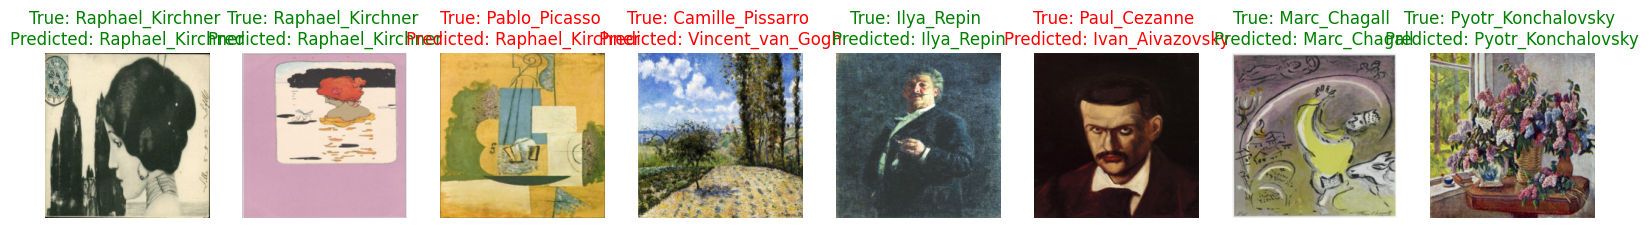

In [ ]:
import torch
import matplotlib.pyplot as plt
import random

# Function to visualize random predictions from test dataset
def visualize_random_predictions(model, dataset, class_mapping, num_samples=8):
    model.eval()  # Set model to evaluation mode
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 8))

    with torch.no_grad():  # Disable gradient calculation for inference
        for i in range(num_samples):
            # Pick a random index from the dataset
            idx = random.randint(0, len(dataset) - 1)
            image, true_label = dataset[idx]

            # Add batch dimension and move image to the appropriate device
            image_batch = image.unsqueeze(0).to(device)

            # Make a prediction
            output = model(image_batch)
            _, predicted_label = torch.max(output, 1)

            # Convert image tensor to numpy and unnormalize
            image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) -> (H, W, C)
            image = (image * 0.5) + 0.5  # Unnormalize image

            # Display the image and predictions
            axes[i].imshow(image)
            axes[i].set_title(
                f"True: {class_mapping['artist_name'][true_label]} \nPredicted: {class_mapping['artist_name'][predicted_label.item()]}",
                color=("green" if true_label == predicted_label.item() else "red"),
                fontsize=12,
            )
            axes[i].axis("off")

    plt.show()


# Visualize random predictions on test dataset (Adjust `num_samples` as needed)
visualize_random_predictions(model, artist_test_balanced_dataset, artist_class, num_samples=8)


In [ ]:
# Hyperparameters
num_epochs_fc = 5  # Train FC layer only for 5 epochs
num_epochs_finetune = 10  # Fine-tune entire model for 10 more epochs
initial_lr = 0.001  # Learning rate for training FC layer
finetune_lr = 1e-4  # Lower learning rate for fine-tuning
batch_size = 32
weight_decay = 1e-4  # L2 regularization


In [ ]:

# Load pre-trained ResNet-18 model
num_classes = len(train_dataset.classes)  # Assuming multi-class classification
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final FC layer
model = model.to(device)

# Define loss function and optimizer for FC layer training
criterion = nn.CrossEntropyLoss()
fc_optimizer = optim.Adam(model.fc.parameters(), lr=initial_lr, weight_decay=weight_decay)

# Function to train the FC layer only
def train_fc_layer():
    print("Starting Step 1: Training FC Layer Only...")
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers except the final FC layer
    model.fc.requires_grad = True  # Unfreeze the FC layer

    for epoch in range(num_epochs_fc):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_fc}]")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            fc_optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            fc_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        print(f"Epoch [{epoch+1}/{num_epochs_fc}], Loss: {running_loss / len(train_loader):.4f}, "
              f"Accuracy: {100 * correct / total:.2f}%")

    print("🎯 Step 1 Complete: FC Layer Training Finished!")


# Step 2: Fine-Tuning Entire Network
def fine_tune():
    print("Starting Step 2: Fine-Tuning the Entire Network...")
    for param in model.parameters():
        param.requires_grad = True  # Unfreeze all layers

    # Define optimizer and scheduler for fine-tuning
    finetune_optimizer = optim.Adam(model.parameters(), lr=finetune_lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(finetune_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    best_val_loss = float('inf')

    for epoch in range(num_epochs_finetune):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=True, desc=f"Epoch [{epoch+1}/{num_epochs_finetune}]")

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            finetune_optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            finetune_optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=running_loss / len(train_loader), acc=100 * correct / total)

        # Validation phase
        val_loss, val_acc = evaluate(val_loader)
        scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{num_epochs_finetune}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {100 * correct / total:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_resnet18_model.pth")
            print("✅ Best model saved!")

    print("🎯 Step 2 Complete: Fine-Tuning Finished!")

# Function to evaluate the model on validation data
def evaluate(loader):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = val_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# Start Training: Step 1 (Train FC Layer) and Step 2 (Fine-Tuning)
train_fc_layer()  # Train the FC layer only
fine_tune()       # Fine-tune the entire ResNet model

print("🎉 Training complete! The best model is saved as 'best_resnet18_model.pth'.")